In [ ]:
import pickle

result_files = {
    "en": "output/allosaurus_en_sr16000_ipa.pkl",
    "es": "output/allosaurus_es_sr16000_ipa.pkl",
}

results = {}
for lang, file in result_files.items():
    with open(file, "rb") as f:
        results[lang] = pickle.load(f)

In [2]:
# parse results:
import pandas as pd
import re

def parse_allosaurus_output(output: str):
    parsed = []
    for line in output.strip().splitlines():
        parts = line.split(maxsplit=2)
        time = float(parts[0])
        duration = float(parts[1])
        # Regex to extract phoneme and probability pairs
        phoneme_probs = re.findall(r'(\S+)\s*\(([\d.]+)\)', parts[2])
        phoneme_probs = [(p, float(prob)) for p, prob in phoneme_probs]
        parsed.append({
            "time": time,
            "duration": duration,
            "phones": phoneme_probs
        })
    return parsed

def get_most_probable_phones(parsed_output):
    most_probable = []
    for entry in parsed_output:
        if entry["phones"]:
            # # Sort phonemes by probability and take the most probable one
            # most_probable_phoneme = max(entry["phonemes"], key=lambda x: x[1])
            # They are already sorted by probability, so we can take the first one
            most_probable_phoneme = entry["phones"][0][0]
            most_probable.append(most_probable_phoneme)
    return most_probable
    
# Extract data from file_name e.g. desde_es061900_es.Argentina.wav -> desde (word), es061900 (id), es.Argentina (accent)
def parse_file_name(file_name):
    parts = file_name.split('_')
    word = parts[0]
    id_ = parts[1]
    accent = '_'.join(parts[2:]).replace('.wav', '')
    return word, id_, accent


parsed = {}
most_probable = {}
for k, v in data.items():
    parsed[k] = parse_allosaurus_output(v)
    most_probable[k] = get_most_probable_phones(parsed[k])

# Cols: file_name, phones
df_phones = pd.DataFrame(most_probable.items(), columns=["file_name", "phone_list"])
df_phones[['word', 'id', 'accent']] = df_phones['file_name'].apply(parse_file_name).apply(pd.Series)
df_phones["phones"] = df_phones["phone_list"].apply(lambda x: " ".join(x))

In [3]:
df_phones.head()

,file_name,phone_list,word,id,accent,phones
0,scarecrow_en1076985_en.uk.general.wav,"[s, k, æ, k, ɹ, ə, w]",scarecrow,en1076985,en.uk.general,s k æ k ɹ ə w
1,dramatically_en027226-55_en.uk.Yorkshire.wav,"[tʂ, ɻ̩, m, ɒ, t͡ɕ, iː, k͡p̚, ʁ, e, i]",dramatically,en027226-55,en.uk.Yorkshire,tʂ ɻ̩ m ɒ t͡ɕ iː k͡p̚ ʁ e i
2,cluttered_en016188_en.Irish.wav,"[n, ɔ, tʰ, ɹ̩, t]",cluttered,en016188,en.Irish,n ɔ tʰ ɹ̩ t
3,untreated_en1095232_en.Jamaica.wav,"[ɒ, n, t, ɹ, i, tʰ, ə, d]",untreated,en1095232,en.Jamaica,ɒ n t ɹ i tʰ ə d
4,distracted_en026186_en.uk.general.wav,"[d, ɪ, s, t, ɹ, æ, k, t, ə, d]",distracted,en026186,en.uk.general,d ɪ s t ɹ æ k t ə d


In [4]:
import numpy as np
import pandas as pd
import plotnine as p9
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, Markdown, Audio


def contains_subsequence(data, pattern):
    m, n = len(data), len(pattern)
    if n == 0:
        return True   # empty pattern “always” matches
    if n > m:
        return False  # pattern longer than data can’t match
    # slide a window of length n over data
    for i in range(m - n + 1):
        if data[i:i+n] == pattern:
            return True
    return False

def coef_plot(df_coefs, top_n=5):
    df_plot = df_coefs.groupby("accent").head(top_n).reset_index(drop=True)
    ncol = 3
    nrow = int(np.ceil(len(df_plot["accent"].unique()) / ncol))
    p = (
        p9.ggplot(
            df_plot,
            p9.aes(x="coef", y="reorder(phone+'::'+accent, coef)")
        )
        + p9.geom_segment(
            p9.aes(xend=0, yend="reorder(phone+'::'+accent, coef)"),
            color="navy", size=1, alpha=0.5
        )
        + p9.geom_point(size=1, color="navy")
        + p9.facet_wrap("accent", scales="free_y", ncol=ncol)
        + p9.scale_y_discrete(labels=lambda lst: [l.split("::")[0] for l in lst])
        + p9.theme_bw()
        + p9.theme(
            figure_size=(2 * ncol, 1.5 * nrow),
            axis_text_x=p9.element_text(rotation=45, hjust=1),
            axis_text_y=p9.element_text(size=10),
        )
        + p9.labs(
            y="", x="",
        )
        
    )
    return df_plot, p

def most_distinctive_phones(df, ngram_order=1):
    """Return a df of logistic regression coefficients for each phone
    for each accent, using n-grams of size ngram_order.
    """
    vectorizer = CountVectorizer(
        lowercase=False,
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(ngram_order, ngram_order),
        min_df=5,     # Minimum document frequency
        binary=True,  # Binary counts (presence/absence of n-grams)
    )

    X_vectorized = vectorizer.fit_transform(df["phone_list"].values)
    y = df["accent"].values
    model = LogisticRegression(max_iter=1000, random_state=33)
    model.fit(X_vectorized, y)
    coefs = model.coef_ 
    # print accuracy:
    maj_class_freq = pd.Series(y).value_counts(normalize=True).max()
    print(f"Accuracy: {model.score(X_vectorized, y):.3f} (maj class freq: {maj_class_freq:.3f})")
    # If binary, add first line with negative coefficients:
    if len(model.classes_) == 2:
        coefs = np.vstack([-coefs[0], coefs])
    df_coefs = pd.DataFrame(
        coefs.T, 
        index=vectorizer.get_feature_names_out(),
        columns=model.classes_,
    ).reset_index().rename(columns={"index": "phone"})
    # To long format:
    df_coefs_long = df_coefs.melt(id_vars=["phone"], var_name="accent", value_name="coef")
    df_coefs_long = df_coefs_long.sort_values(by=["accent", "coef"], ascending=[True, False])
    return df_coefs_long

def show_examples(df, phone_ngram, accent, wavs_path="output/words_wav/en/sr16000", seed=33, n=3):
    """For a given phone ngram (list of phones in order) and an accent,
    show examples of words and their audios.
    """
    df_accent = df[df["accent"] == accent].copy()
    df_filtered = df_accent[df_accent["phone_list"].apply(lambda x: contains_subsequence(x, phone_ngram))]
    if df_filtered.empty:
        print(f"No examples found for phone ngram {phone_ngram} in accent {accent}.")
    else:
        df_filtered = df_filtered.sample(n=min(n, len(df_filtered)), random_state=seed)
        for _, row in df_filtered.iterrows():
            word = row["word"]
            phones_str = row["phones"]
            audio_file = f"{wavs_path}/{row['file_name']}"
            display(Markdown(f"{phone_ngram} as in **{word}** ({accent}): [{phones_str}]"))
            display(Audio(audio_file, autoplay=False))

def play_audio(df, word, accents: list = None):
    """Play audio for a given word and accent."""
    df_filtered = df[(df["word"] == word)]
    if accents is not None:
        df_filtered = df_filtered[df_filtered["accent"].isin(accents)]
    if df_filtered.empty:
        print(f"No audio found for word '{word}' in accents {accents}.")
    else:
        for _, row in df_filtered.iterrows():
            audio_file = f"{AUDIO_PATH}/{row['file_name']}"
            word = row["word"]
            phones_str = row["phones"]
            accent = row["accent"]
            display(Markdown(f"**{word}** ({accent}): [{phones_str}]"))
            # Play audio
            display(Audio(audio_file, autoplay=False))            

In [5]:
AUDIO_PATH = "output/words_wav/en/sr16000"

def run_everything(ngram_order = 1, accents = None, seed=33):
    if accents is None:
        accents = df_phones["accent"].unique().tolist()
    df_filtered = df_phones[df_phones["accent"].isin(accents)].copy()
    df_coefs = most_distinctive_phones(df_filtered, ngram_order=ngram_order)
    # # vec, mod = most_distinctive_phones(df_filtered, ngram_order=ngram_order)
    # return vec, mod
    df_plot, p = coef_plot(df_coefs, top_n=5)
    p.show()
    for _, row in df_plot.iterrows():
        phone_ngram = row["phone"].split(" ")
        accent = row["accent"]
        # print(row)
        # print()
        show_examples(df_phones, phone_ngram, accent, wavs_path=AUDIO_PATH, seed=seed, n=1)

In [6]:
print("Accents: " + ", ".join(df_phones["accent"].unique().tolist()))

Accents: en.uk.general, en.uk.Yorkshire, en.Irish, en.Jamaica, en.us.south, en.Australian, en.us.us, en.scot, en.uk.rp


Accuracy: 0.525 (maj class freq: 0.338)


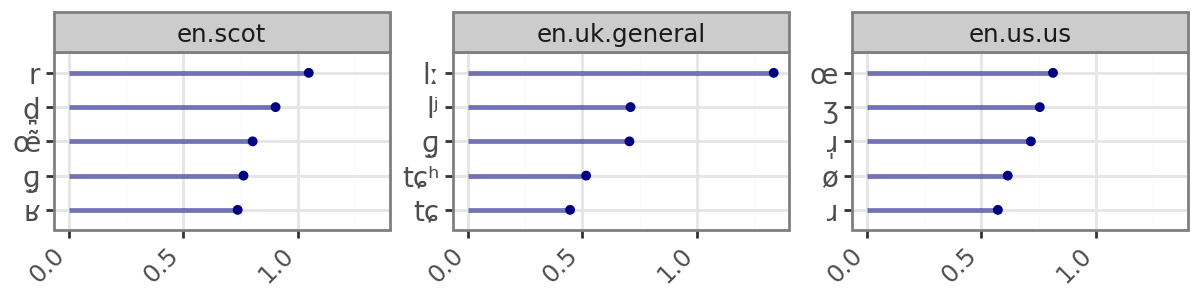

['r'] as in **plagiarize** (en.scot): [l̪ i j d͡ʒ u r a j z]

['d̪'] as in **selfless** (en.scot): [d̪ i o ʁ uə l ɒ]

['œ̃'] as in **psychiatric** (en.scot): [s uə a j k ij iː œ̃ t ɹ ɪ k]

['ɡ̤'] as in **sulky** (en.scot): [tʂ o uə ɡ̤ e ɪ]

['ʁ'] as in **cut** (en.scot): [tʰ o ʁ]

['lː'] as in **belittle** (en.uk.general): [b̞ iː lː e tʂ uə o]

['lʲ'] as in **unwieldy** (en.uk.general): [ɒ ɳ w iː o uə lʲ e]

['ɡ̤'] as in **enigma** (en.uk.general): [ʔ ɛ ɳ n e ɡ̤ m ʌ ə]

['tɕʰ'] as in **fetching** (en.uk.general): [ts a ɪ tɕʰ i iː]

['tɕ'] as in **hiking** (en.uk.general): [x a ɪ tɕ i ŋ]

['œ'] as in **cynical** (en.us.us): [s œ n ə k uə]

['ʒ'] as in **disclosure** (en.us.us): [d ɪ s k l o w ʒ ɹ̩]

['ɹ̩'] as in **consider** (en.us.us): [k ə n sː ɪ ɾ ɹ̩]

['ø'] as in **studious** (en.us.us): [s t ø ɾ i ɪ s]

['ɹ'] as in **absorbing** (en.us.us): [ə b z ɔ ɹ b ɪ ŋ]

In [7]:
# run_everything(ngram_order=1, accents=["en.uk.general", "en.uk.rp"])
run_everything(ngram_order=1, accents=["en.scot", "en.us.us", "en.uk.general"], seed=36)
# NOTE if binary, the coeff for the negative class are the negative of the overall coeffs.
# So the left plot displays the largest negative coefficients in absolute value.

In [8]:
# play_audio(df_phones, "hiss", ["en.uk.general"])
play_audio(df_phones, "disclosure", ["en.uk.general", "en.scot", "en.us.us"])

**disclosure** (en.uk.general): [d ɪ s k l o w ʐ j ə]

**disclosure** (en.us.us): [d ɪ s k l o w ʒ ɹ̩]

**disclosure** (en.scot): [d ɪ s k l o d͡ʒ ɹ̩]

Accuracy: 0.629 (maj class freq: 0.338)


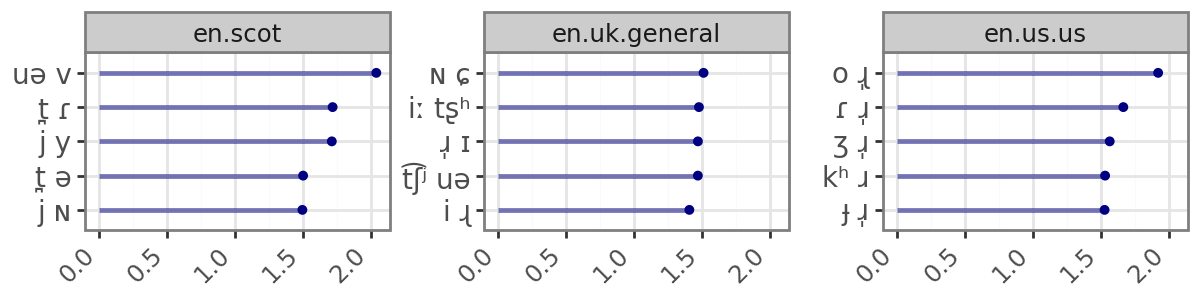

['uə', 'v'] as in **oversight** (en.scot): [uə v ɹ̩ s a j tʰ]

['t̪', 'ɾ'] as in **grieve** (en.scot): [t̪ ɾ y ŋ iː s̪]

['j', 'y'] as in **pecuniary** (en.scot): [ð ə t͡ʃʲ j y n i ə l i]

['t̪', 'ә'] as in **dampen** (en.scot): [tʂ ɒ m t̪ ә n]

['j', 'ɴ'] as in **angina** (en.scot): [ɒ n d͡ʒ o j ɴ n ə]

['ɴ', 'ɕ'] as in **ginger** (en.uk.general): [tʂ y æ n ɴ ɕ ʌ]

['iː', 'tʂʰ'] as in **bigoted** (en.uk.general): [ð e ɪ g iː tʂʰ ə]

['ɹ̩', 'ɪ'] as in **flickering** (en.uk.general): [f l ɪ k ɹ̩ ɪ ŋ]

['t͡ʃʲ', 'uə'] as in **literally** (en.uk.general): [lʲ e tʰ t͡ʃʲ uə o l̪ l e]

['i', 'ɻ'] as in **feeling** (en.uk.general): [f i ɻ ʌ ɪ ŋ]

['o', 'ɻ̩'] as in **sharpener** (en.us.us): [ɕ ɔ o ɻ̩ ʀ ʌ ɪ ɲ ə]

['ɾ', 'ɹ̩'] as in **glitter** (en.us.us): [g w ɪ ɾ ɹ̩]

['ʒ', 'ɹ̩'] as in **displeasure** (en.us.us): [tʲ ɪ s p l ɛ ʒ ɹ̩]

['kʰ', 'ɹ'] as in **col** (en.us.us): [kʰ ɹ ɒ]

['ɟ', 'ɹ̩'] as in **garret** (en.us.us): [ɟ ɹ̩ ɹ ə tʰ s]

In [9]:
# run_everything(ngram_order=1, accents=["en.uk.general", "en.uk.rp"])
run_everything(ngram_order=2, accents=["en.scot", "en.us.us", "en.uk.general"], seed=36)
# NOTE if binary, the coeff for the negative class are the negative of the overall coeffs.
# So the left plot displays the largest negative coefficients in absolute value.

Accuracy: 0.657 (maj class freq: 0.338)


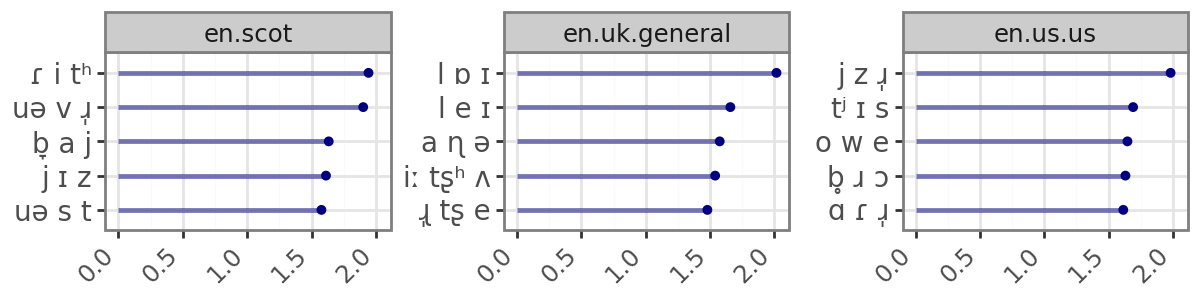

['ɾ', 'i', 'tʰ'] as in **recuperate** (en.scot): [ɨ ð tʲ u p uə ɾ i tʰ s]

['uə', 'v', 'ɹ̩'] as in **overpass** (en.scot): [uə v ɹ̩ p a s]

['b̞', 'a', 'j'] as in **bye** (en.scot): [b̞ a j]

['j', 'ɪ', 'z'] as in **improvisation** (en.scot): [ɪ m p ɹ ə v a j ɪ z e j ʃ ə n]

['uə', 's', 't'] as in **ghost** (en.scot): [g uə s t]

['l', 'ɒ', 'ɪ'] as in **elderly** (en.uk.general): [a w l̪ tʂ ɨ l ɒ ɪ]

['l', 'e', 'ɪ'] as in **blatantly** (en.uk.general): [l̪ a ɪ tʂ ɔ̃ ɴ p l e ɪ]

['a', 'ɳ', 'ә'] as in **unfeasible** (en.uk.general): [a ɳ ә f i z ə b̥ ə uə]

['iː', 'tʂʰ', 'ʌ'] as in **competency** (en.uk.general): [kʰ a ɴ p iː tʂʰ ʌ ŋ s̪ e]

['ɻ̩', 'tʂ', 'e'] as in **levity** (en.uk.general): [l̪ ɒ v ɻ̩ tʂ e]

['j', 'z', 'ɹ̩'] as in **miserly** (en.us.us): [m a j z ɹ̩ l i]

['tʲ', 'ɪ', 's'] as in **dissimilar** (en.us.us): [tʲ ɪ s ɪ m ə l ɹ̩]

['o', 'w', 'e'] as in **fluidity** (en.us.us): [f l̪ o w e ɪ ɾ ɹ̩ t̪ʰ i]

['b̥', 'ɹ', 'ɔ'] as in **brotherhood** (en.us.us): [b̥ ɹ ɔ ð ɹ̩ h ʌ]

['ɑ', 'ɾ', 'ɹ̩'] as in **moderately** (en.us.us): [m ɑ ɾ ɹ̩ ə tʰ l i]

In [10]:
run_everything(ngram_order=3, accents=["en.scot", "en.us.us", "en.uk.general"], seed=36)

### Distances

In [58]:
# Create df with cols: word, accents (N cols), phones:
df_words = df_phones.pivot_table(index=["word", "id"], columns="accent", values="phone_list", aggfunc="first").reset_index()
df_words.query("word == 'usa'")

accent,word,id,en.Australian,en.Irish,en.Jamaica,en.scot,en.uk.Yorkshire,en.uk.general,en.uk.rp,en.us.south,en.us.us
34940,usa,en094706,NaN,"[t͡ɕ, uə, b̞, a, ɪ, s, ɒ]","[ɲ, o, uə, ɛ, sː, e]","[j, uə, e, ʂ, ɻ̩, e]",NaN,"[iː, w, ɒ, s, a]","[j, y, ɛ, s, ɒ, j]","[iː, w, e, f, ɤ̆]","[j, u, ɒ, s, ɒ]"
34941,usa,en094706-55,NaN,NaN,NaN,NaN,"[iː, a, sː, ɒ]",NaN,NaN,NaN,NaN


In [59]:
df_words.query("word == 'usa'")["en.Australian"].iloc[0]

nan

In [100]:
def my_levenshtein(a, b):
    """Because the original one fails with IPA characters"""
    n, m = len(a), len(b)
    # initialize distance matrix
    dp = [[0] * (m + 1) for _ in range(n + 1)]
    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j
    # fill matrix
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if a[i - 1] == b[j - 1] else 1
            dp[i][j] = min(
                dp[i - 1][j] + 1,      # deletion
                dp[i][j - 1] + 1,      # insertion
                dp[i - 1][j - 1] + cost  # substitution
            )
    return dp[n][m]

In [101]:
from itertools import combinations

import Levenshtein
from nltk.metrics.aline import delta, align

accent_cols = [col for col in df_words.columns if col not in ['word', 'id']]
results = []
for _, row in df_words.iterrows():
    word = row['word']
    wordid = row['id']
    for acc1, acc2 in combinations(accent_cols, 2):
        phones1 = row[acc1]
        phones2 = row[acc2]
        if not (isinstance(phones1, list) and isinstance(phones2, list)):
            l_dist = k_dist = None
        elif len(phones1) == 0 or len(phones2) == 0:
            l_dist = k_dist = None
        else:
            phone_str_1 = "".join(phones1)
            phone_str_2 = "".join(phones2)
            # l_dist = Levenshtein.distance(phone_str_1, phone_str_2)
            l_dist = my_levenshtein(phones1, phones2)
            # k_dist = delta(phones1, phones2)  # TODO this fails!
        results.append({
            'word': word,
            'wordid': wordid,
            'accent1': acc1,
            'accent2': acc2,
            'phones1': phones1,
            'phones2': phones2,
            'l_dist': l_dist,
            # 'kondrak_distance': k_dist, # TODO this fails!
            # 'n_phones': TODO, # using phone_list
        })
        # if word == "zucchini":
        # # if wordid == "en100165-55":
        #     print(f"Word: {word}, Accents: {acc1}, {acc2}, Phones: {row[acc1]}, {row[acc2]}, Levenshtein: {l_dist}")

In [102]:
df_dist = pd.DataFrame(results)
dd = df_dist.sort_values(by='l_dist', ascending=False)

In [103]:
dd.head(2)

,word,wordid,accent1,accent2,phones1,phones2,l_dist
592791,inadvertently,en1044887,en.Jamaica,en.scot,"[j, u, n, ɒ, tʰ, v, ɹ̩, tʲ, ɛ, n, t, ə, l̪, i]","[ɒ, n, ɴ, ə, tʂ, ə, b, e, j, a, ɾ, o, tʂ, ʌ, ŋ...",18.0
1206105,transport,en091644,en.uk.rp,en.us.south,"[tʂʰ, ɹ, æ, n, ɳ, s, p, ɔ, ɹ, tʰ, ɔ, ɹ, t, ɹ, ...","[t, ɹ, e, j, n, z, tː, ɔ, w, ɹ̩]",18.0


In [104]:
dd.query("word == 'faq'")

,word,wordid,accent1,accent2,phones1,phones2,l_dist
429410,faq,en1032377,en.Australian,en.scot,"[e, f, a, ɪ, t͡ɕ, iː]","[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...",18.0
429431,faq,en1032377,en.scot,en.uk.rp,"[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...","[ɒ, f, e, j, tɕʰ, iː]",18.0
429430,faq,en1032377,en.scot,en.uk.general,"[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...","[ʔ, ɒ, f, ɒ, ɪ, t͡ɕ, iː, ə]",17.0
429432,faq,en1032377,en.scot,en.us.south,"[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...","[ɛ, f, a, ɪ, i]",17.0
429417,faq,en1032377,en.Irish,en.scot,"[a, ɪ, f, ɒ, k, iː]","[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...",17.0
...,...,...,...,...,...,...,...
429475,faq,en1032377-55,en.uk.general,en.us.south,NaN,NaN,NaN
429476,faq,en1032377-55,en.uk.general,en.us.us,NaN,NaN,NaN
429477,faq,en1032377-55,en.uk.rp,en.us.south,NaN,NaN,NaN
429478,faq,en1032377-55,en.uk.rp,en.us.us,NaN,NaN,NaN


In [106]:
dd_res = dd.dropna(subset=["l_dist"]).copy()
dd_res["n_set_phones"] = (
    dd_res.apply(lambda row: len(set(row["phones1"]) | set(row["phones2"])), axis=1)
)
dd_res["rel_dist"] = dd_res["l_dist"] / dd_res["n_set_phones"]

In [107]:
dd_res.sort_values(by="rel_dist", ascending=False) #.head(10)

,word,wordid,accent1,accent2,phones1,phones2,l_dist,n_set_phones,rel_dist
812963,ow,en061237,en.Irish,en.uk.general,[ɒ],"[ʔ, ɒ, ʔ, ɒ]",3.0,2,1.500000
429423,faq,en1032377,en.Jamaica,en.scot,"[ɛ, k, j, u]","[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...",17.0,12,1.416667
18510,admirable,en1001973,en.Australian,en.us.south,[ə],"[æ, tʰ, m, æ, ə, m, ə, l̪]",7.0,5,1.400000
429432,faq,en1032377,en.scot,en.us.south,"[k, l, i, k, w, ə, n, l, i, æ, s, k, w, ɛ, s, ...","[ɛ, f, a, ɪ, i]",17.0,13,1.307692
1206102,transport,en091644,en.uk.general,en.uk.rp,"[tʂ, æ, n, s, p, ɔ, ɹ, tʰ]","[tʂʰ, ɹ, æ, n, ɳ, s, p, ɔ, ɹ, tʰ, ɔ, ɹ, t, ɹ, ...",14.0,11,1.272727
...,...,...,...,...,...,...,...,...,...
471687,foxy,en1035243,en.Jamaica,en.scot,"[f, ɑ, k, s, i]","[f, ɑ, k, s, i]",0.0,5,0.000000
1001555,sarcasm,en1076479,en.us.south,en.us.us,"[s, ɑ, ɾ, k, æ, z, ə, m]","[s, ɑ, ɾ, k, æ, z, ə, m]",0.0,8,0.000000
1002203,sassy,en075168,en.us.south,en.us.us,"[s, æ, s, i]","[s, æ, s, i]",0.0,3,0.000000
470543,fosse,en1035193,en.scot,en.uk.rp,"[p, ɔ, s]","[p, ɔ, s]",0.0,3,0.000000


In [95]:
play_audio(df_phones, "gaga")


**gaga** (en.uk.general): [b i a ŋ ɒ t͡ɕ ɤ]

**gaga** (en.Irish): [t͡ɕ i ɒ k ɒ]

**gaga** (en.us.us): [t͡ɕ a t͡ɕ ɤ]

**gaga** (en.Australian): [k æ k͡p̚ ɒ]

**gaga** (en.us.south): [ɡ̤ ɤ ɡ̤ ɤ]

**gaga** (en.uk.Yorkshire): [t͡ɕ ɒ t͡ɕ ɨ ɴ]

**gaga** (en.uk.rp): [t͡ɕ a ŋ k a]

**gaga** (en.scot): [t͡ɕ ɤ k͡p̚ i]

**gaga** (en.Jamaica): [k͡p̚ ɤ k͡p̚ ɒ]

In [109]:
# Avg rel distance:
avg_rel_dist = dd_res.groupby(["accent1", "accent2"])["rel_dist"].mean().reset_index()
avg_rel_dist = avg_rel_dist.sort_values(by="rel_dist", ascending=False)
avg_rel_dist #.head(10)

,accent1,accent2,rel_dist
20,en.scot,en.us.south,0.484009
2,en.Australian,en.scot,0.483045
1,en.Australian,en.Jamaica,0.482328
16,en.Jamaica,en.us.south,0.476697
5,en.Australian,en.us.south,0.474473
13,en.Jamaica,en.scot,0.468674
23,en.uk.general,en.us.south,0.467536
14,en.Jamaica,en.uk.general,0.461746
18,en.scot,en.uk.general,0.458269
15,en.Jamaica,en.uk.rp,0.457579


--------------------------

In [97]:
!pip install -qU strsimpy

In [111]:
from strsimpy.levenshtein import Levenshtein as ll
import Levenshtein

x = ["k͡p̚", "ɤ", "k͡p̚", "ɒ"]
y = ["ɡ̤", "ɤ", "ɡ̤", "ɤ"]


print(Levenshtein.distance("".join(x), "".join(y)))
levenshtein = ll()
print(levenshtein.distance("".join(x), "".join(y)))
print(my_levenshtein(x, y))

9
9
3


9


In [ ]:
play_audio(df_phones, "zucchini")


**zucchini** (en.uk.rp): [ʂ ɒ kʰ iː n iː]

**zucchini** (en.uk.Yorkshire): [ʂ o uə pʰ i ɴ n iː]

**zucchini** (en.us.us): [ʂ ɻ̩ ŋ tʂ e ɴ i]

**zucchini** (en.us.south): [ʀ e u uə kʰ i m i ŋ]

**zucchini** (en.Jamaica): [ʂ ʌ k̟ʲ iː ɳ i]

**zucchini** (en.scot): [ʂ ɻ̩ tɕ i ɴ i]

**zucchini** (en.Irish): [z ə uə pʰ i n i]

**zucchini** (en.uk.general): [s̪ ɻ̩ tɕ e n e ɪ]

**zucchini** (en.uk.rp): [ʂ ɒ kʰ iː n iː]

**zucchini** (en.uk.Yorkshire): [ʂ o uə pʰ i ɴ n iː]

**zucchini** (en.us.us): [ʂ ɻ̩ ŋ tʂ e ɴ i]

**zucchini** (en.us.south): [ʀ e u uə kʰ i m i ŋ]

**zucchini** (en.Jamaica): [ʂ ʌ k̟ʲ iː ɳ i]

**zucchini** (en.scot): [ʂ ɻ̩ tɕ i ɴ i]

**zucchini** (en.Irish): [z ə uə pʰ i n i]

**zucchini** (en.uk.general): [s̪ ɻ̩ tɕ e n e ɪ]

In [30]:
x = df_phones["phone_list"].iloc[0]
y = df_phones["phone_list"].iloc[1]
xx = df_phones["phones"].iloc[0].replace(" ", "")
yy = df_phones["phones"].iloc[1].replace(" ", "")

In [31]:
xx, yy

('skækɹəw', 'tʂɻ̩mɒt͡ɕiːk͡p̚ʁei')

In [32]:
align(xx, yy)

KeyError: '̩'

In [24]:
x = df_phones["phone_list"].iloc[0]
y = df_phones["phone_list"].iloc[1]

In [25]:
delta(x, y)

TypeError: unhashable type: 'list'

In [37]:
from IPython.display import display, HTML

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [ ]:
 # TODO should use IDs!
pretty_print(dd.head(10))

,word,wordid,accent_pair,phones_pair,l_distance
54126,usa,es195566,es.Argentina-es.Castellano,[ʔ u t a][ɪ s t a ð o s u n i ð o uə s ð e ə a m e ɾ i k a],43.0
54128,usa,es195566,es.Castellano-es.Mexico,[ɪ s t a ð o s u n i ð o uə s ð e ə a m e ɾ i k a][uə s ɒ n],42.0
44846,rae,es161488,es.Castellano-es.Mexico,[b ɾ e a l a k a ð e m j ɪ e s p a ɲ o n ɪ][d̪ ʌ r ɒ],38.0
44844,rae,es161488,es.Argentina-es.Castellano,[d̪ uə ɾ a][b ɾ e a l a k a ð e m j ɪ e s p a ɲ o n ɪ],37.0
53900,ue,es194697,es.Castellano-es.Mexico,[u n j o n e u uə ɾ o p e ɪ a][k͡p̚ e],26.0
53898,ue,es194697,es.Argentina-es.Castellano,[ʔ w e][u n j o n e u uə ɾ o p e ɪ a],25.0
26226,galgo,es094728,es.Argentina-es.Castellano,[g a l uə ɡ o][t̪ʰ iː ɴ ɡ̤ ɒ s̪ iː k͡p̚ uə o],23.0
546,abrevadero,es001401,es.Argentina-es.Castellano,[ʔ ɒ b̞ ʌ ɾ i ɪ b̞ a ð i ɾ o][ɒ p uə ɾʲ e b̞ ɒ o t̪ uə e ɪ tʂ o uə],23.0
4898,arrebatado,es017301,es.Castellano-es.Mexico,[ɒ tʂ ɾ ʌ ɪ b̞ a n t͡ɕ i a ŋ d o][ʏ b̞ ɒ t a],23.0
15492,cuidador,es055637,es.Argentina-es.Castellano,[w i ð æ ð o ɾ][k͡p̚ uə e ɪ tɕ i a ts ɒ o tʂ ɹ̩],23.0


In [39]:
dd = df_dist.sort_values(by='l_distance', ascending=False).query("l_distance < 20").head(20)
pretty_print(dd)

,word,wordid,accent_pair,phones_pair,l_distance
42531,positivismo,es153631,es.Argentina-es.Castellano,[ʔ o s̪ iː t̪ i b̞ e m a][p o ʂ uə ɪ t iː b̞ iː ʂ ɻ̩ m ɒ o],19.0
12117,cohesionar,es043302,es.Argentina-es.Castellano,[o ɪ s̪ j o n æ ɾ][k͡p̚ uə o l̪ b̞ e ɕ i o n a],19.0
548,abrevadero,es001401,es.Castellano-es.Mexico,[ɒ p uə ɾʲ e b̞ ɒ o t̪ uə e ɪ tʂ o uə][ʔ ɒ b ʌ ɾ e ɪ b̞ a d e ɪ ɾ uə],19.0
29046,ignominia,es104798,es.Argentina-es.Castellano,[i k͡p̚ ʌ n ɴ d ɒ o m iː ɲ i æ n][i n o m ɪ n iː ə],19.0
26235,gallego,es094764,es.Argentina-es.Castellano,[d æ tʂ e ɡ o][iː ɴ k a d͡ʒ i e k͡p̚ uə o],19.0
8442,bárbaro,es023980,es.Argentina-es.Castellano,[b̥ ʌ tʰ][n p a ʂ ɻ̩ p a ɾ o uə],19.0
4984,arriesgado,es017608,es.Argentina-es.Mexico,[a ɾ i e ɕ a ð uə][ʔ ɒ k͡p̚ ɾ j e ʂ g i æ s o ŋ],19.0
13486,conocedor,es048447,es.Argentina-es.Mexico,[k͡p̚ o n o f ɪ ð uə o ɾ][k uə o n ɴ n o uə ɕ i e d a ɒ ð ɾ],19.0
10317,caverna,es036728,es.Argentina-es.Castellano,[ɾ][t͡ɕ ɒ a b̞ e ɾ ә n ɪ],19.0
53012,transparencia,es191843,es.Castellano-es.Mexico,[t ɾ a ɪ e ɳ n ә s p a lʲ i n tʰ i a][ɾ ɒ n p a ɾ ʌ e n ɕ i a],19.0


In [21]:
from IPython.display import Audio, display, Markdown
from pathlib import Path

def play_audio(word, accent, path_prefix="output/words_wav/es/sr16000"):
    # find wav file containing word and accent:
    audio_files = list(Path(path_prefix).glob(f"{word}_*{accent}.wav"))
    if not audio_files:
        print(f"No audio files found for {word} with accent {accent}")
        return
    audio_path = audio_files[0]  # Take the first matching file
    try:
        display(Markdown(f"**{word}** ({accent})"))
        display(Audio(audio_path, autoplay=True))
    except FileNotFoundError:
        print(f"Audio file not found: {audio_path}")

In [44]:
play_audio("taberna", "es.Mexico")
play_audio("caverna", "es.Mexico")
play_audio("taberna", "es.Argentina")
play_audio("caverna", "es.Argentina")

**taberna** (es.Mexico)

**caverna** (es.Mexico)

**taberna** (es.Argentina)

**caverna** (es.Argentina)

In [23]:
play_audio("w", "es.Argentina")
play_audio("w", "es.Castellano")

**w** (es.Argentina)

**w** (es.Castellano)

In [48]:
mask = df_phones['word'].str.contains('caverna|taberna')
df_phones[mask].sort_values(["accent", "id"])

,file_name,phone_list,word,id,accent,phones
44906,caverna_es036728_es.Argentina.wav,[ɾ],caverna,es036728,es.Argentina,ɾ
29094,taberna_es184465_es.Argentina.wav,"[t, ɒ, b, e, ɾ, ɴ, ɪ]",taberna,es184465,es.Argentina,t ɒ b e ɾ ɴ ɪ
35824,caverna_es036728_es.Castellano.wav,"[t͡ɕ, ɒ, a, b̞, e, ɾ, ә, n, ɪ]",caverna,es036728,es.Castellano,t͡ɕ ɒ a b̞ e ɾ ә n ɪ
34710,taberna_es184465_es.Castellano.wav,"[t͡ɕ, ɒ, p, i, ə, ɾ, ә, ŋ̟, d, ɒ]",taberna,es184465,es.Castellano,t͡ɕ ɒ p i ə ɾ ә ŋ̟ d ɒ
28014,caverna_es036728_es.Mexico.wav,"[t͡ɕ, a, b̞, e, ɾ, ʔ, ɪ]",caverna,es036728,es.Mexico,t͡ɕ a b̞ e ɾ ʔ ɪ
24292,taberna_es184465_es.Mexico.wav,"[t, ɒ, b̞, e, ɴ, ɾ, m, ɒ]",taberna,es184465,es.Mexico,t ɒ b̞ e ɴ ɾ m ɒ


In [14]:
# from gruut_ipa import Pronunciation

# # ipa_string = "ˈjɛs|ˈt͡ʃuːz aɪpiːeɪ‖"
# ipa_string = "l̪ l a t͡ɕ t̪ i k͡p̚ o"

# res = Pronunciation.from_string(ipa_string).phones


## OLD

In [ ]:
def get_examples_for_top_features(df, top_features, n_examples=3):
    examples = {}
    for class_label, features in top_features.items():
        examples[class_label] = {}
        for feature, coef in features:
            # Get rows where the feature appears
            rows = df[df['phone_list'].apply(lambda x: contains_subsequence(x, feature.split()))]
            # Take up to n_examples in format "word (phones), word (phones), ..."
            res = rows["word"] + " (" + rows["phones"] + ")"
            # Store the examples
            examples[class_label][feature] = ", ".join(
                res.head(n_examples).values
            )
            
    return examples


def get_top_features_per_class(model, vectorizer, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    coefs = model.coef_
    classes = model.classes_

    top_features = {}
    for i, class_label in enumerate(classes):
        class_coefs = coefs[i]
        # # Get indices of top features in absolute value
        # top_indices = np.argsort(np.abs(class_coefs))[-top_n:][::-1]
        # Get indices of top features in absolute value
        top_indices = np.argsort(class_coefs)[-top_n:][::-1]
        # Get feature names and their corresponding coefficients
        top_features[class_label] = [(feature_names[idx], class_coefs[idx]) for idx in top_indices]
    return top_features
